# Classification de genres musicaux : prédiction du genre d'une chanson


Le développement réçent des plateformes de streaming musical comme Spotify a rendu crucial l'analyse et la catégorisation des données musicales, afin de mieux organiser ces données sur ces plateformes. Pour cela il est nécessaire de mieux comprendre les chansons, et ce qui les rend différentes les unes des autres.

Une première approche pour classer les chansons est celle du genre musical : celui-ci définit l'appartenance d'une musique à un groupe, un style musical qui lui est propre. Cette appartenance se base en partie sur des caractéristiques sonores communes, même si une dimension culturelle entre aussi en jeu. Nous avons ainsi décider de nous pencher sur la prédiction du genre d'une chanson en fonction de certains de ses attributs audio. Un tel outil de prédiction est aujourd'hui essentiel pour les plateformes de streaming musical.


Nous avons dans un premier temps travaillé à créer une base de données contenant des features pertinentes. N
Nous avons pour cela scrappé 15399 morceaux, 1711 morceaux pour chacun des neuf genres distincts choisis : rock, metal, jazz, blues, disco, house, classique, hip-hop et country. Les features de ces morceaux ont été séparés en 3 bases distinctes : la première regroupe des attributs audios relatifs à chaque chanson, la seconde ses premières notes et la dernière ses premiers timbres. 

La seconde étape à été la visualisation de ces différentes features et de leur articulation par rapport au genre de la musique, ainsi que l'évaluation de leur pertinence. Nous avons également créé a partir de ces première bases d'autres features, parfois plus judicieuses ou succintes, avec lesquelles travailler.

Une fois ces caractéristiques extraites, nous avons évalué les performances de différents modèles de prédiction "classiques" d'apprentissage supervisé, que nous avons comparé. Nous avons finalement également tenter d'approcher le problème du point de vue du deep learning en faisant appel à un réseau de neurones pour l'apprentissage.  

# 1. Scrapping de la base

In [2]:
#A voir si je rajoute juste le lien du notebook ou si je les fusionne ?

Nous avons scrappé 15399 morceaux, dont les features ont été séparés en 3 bases distinctes. 

- La première, df_track regroupe l'id, le titre et genre du morceaux ainsi que des caractéristiques comme son "énergie" (sorte de note entre 0 et 1), son tempo, sa durée etc. Nous avons notamment scrappé 1711 morceaux pour chacun des 9 genres différents. 
- Le seconde, df_pitches regroupe l'id et les 125 premiers chromagrammes de ces morceaux : un chromagramme est un vecteur de 12 coefficients (correspondant aux 12 classes de notes) contenant des valeurs allant de 0 à 1 qui décrivent la dominance relative de chaque "hauteur" dans l'échelle chromatique.
- La dernière, df_timbres regroupe l'id et les 125 premières fonction de timbres : vecteur de 12 coefficients centrés autour de 0, nous informant sur la surface spectrale du son, classées par degré d'importance (le premier représente le volume sonore moyen du segment, le seconde la luminosité etc.)

# 2. Première visualisation et statistiques descriptives de la base 

In [90]:
# !pip install -r requirements.txt

In [61]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Approche machine learning
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier

# Approche deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
df_track = pd.read_csv(os.path.join('Database','tracksMeta_new.csv'), index_col = 0)
df_pitches = pd.read_csv(os.path.join('Database','tracksPitches.csv'), index_col = 0)
df_timbres = pd.read_csv(os.path.join('Database','tracksTimbres.csv'), index_col = 0)

## 2. 1. Description des features

### 2. 1. 1. Première description  

In [3]:
list(df_track.columns.values)

['track_name',
 'track_artists',
 'genre',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms',
 'time_signature']

In [357]:
df_track.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,15399.000000,15399.000000,15399.000000,15399.000000,15399.000000,15399.000000,15399.000000,15399.000000,15399.000000,15399.000000,15399.000000,1.539900e+04,15399.000000
mean,0.567041,0.584243,5.284434,-10.443700,0.652835,0.087688,0.342614,0.242531,0.220646,0.514945,119.063478,2.397844e+05,3.889798
std,0.182779,0.288151,3.554432,6.453283,0.476084,0.094491,0.362902,0.359398,0.206601,0.249606,29.506190,1.124725e+05,0.421372
min,0.000000,0.000129,0.000000,-41.149000,0.000000,0.000000,0.000000,0.000000,0.011900,0.000000,0.000000,3.149300e+04,0.000000
25%,0.439000,0.361500,2.000000,-13.066000,0.000000,0.037600,0.016700,0.000003,0.096500,0.324000,96.021000,1.757170e+05,4.000000
50%,0.580000,0.638000,5.000000,-8.520000,1.000000,0.050000,0.174000,0.002580,0.130000,0.519000,118.383000,2.208670e+05,4.000000
75%,0.707000,0.835000,9.000000,-5.813500,1.000000,0.090050,0.687000,0.540500,0.278000,0.713000,136.927500,2.775600e+05,4.000000
max,0.988000,1.000000,11.000000,0.642000,1.000000,0.962000,0.996000,0.988000,0.995000,0.991000,239.848000,2.669911e+06,5.000000


In [358]:
print(df_track['mode'].unique())
print(df_track['key'].unique())
print(df_track['time_signature'].unique())

[1. 0.]
[ 1.  9.  2.  7.  4.  6. 10. 11.  5.  0.  3.  8.]
[4. 5. 3. 1. 0.]


- Les features danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence prennent des valeurs entre 0 et 1 évaluant le "niveau" de cet attribut pour chaque morceau.

- La features duration_ms correspond à la durée en ms du morceau, et le tempo au nombre de battements par minute.

- D'autres features prennent un éventail restreint de valeurs discrètes : 0 ou 1 pour mode, un entier entre 0 et 11 pour key et un entier entre 0 et 5 pour time_signature.

### 2. 1. 2. Corrélation entre les différentes caractéristiques :

On veut éviter les caractéristiques fortement corrélées pour éviter que ces dernières soit redondantes. En effet,  garder uniquement les features pertinentes simplifie le modèle et évite l'overfitting, et permet également des temps de calculs moins long.

In [359]:
#On observe la corrélation entre les features 
corr_metrics = df_track.corr(method='pearson')

#Pour que ce soit plus visuel : plus la corrélation entre deux features est importante, plus la case est foncée
corr_metrics.style.background_gradient()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
danceability,1.000000,0.124636,0.016788,0.218414,-0.071313,0.164990,-0.228194,-0.148524,-0.189146,0.463253,-0.109292,-0.087199,0.186730
energy,0.124636,1.000000,0.030672,0.846501,-0.070838,0.209637,-0.802483,-0.377797,0.210354,0.168035,0.223923,0.190668,0.231023
key,0.016788,0.030672,1.000000,0.021730,-0.161971,0.021667,-0.027739,-0.011184,-0.002169,0.012947,0.000087,0.007615,0.007098
loudness,0.218414,0.846501,0.021730,1.000000,-0.041942,0.195482,-0.726380,-0.522489,0.140895,0.136395,0.184344,0.155213,0.205515
mode,-0.071313,-0.070838,-0.161971,-0.041942,1.000000,-0.073396,0.089442,-0.048148,0.033401,0.020900,0.017605,-0.039927,-0.037598
speechiness,0.164990,0.209637,0.021667,0.195482,-0.073396,1.000000,-0.184934,-0.200132,0.122657,0.036995,0.025177,-0.029722,0.058947
acousticness,-0.228194,-0.802483,-0.027739,-0.726380,0.089442,-0.184934,1.000000,0.366671,-0.103642,-0.090754,-0.180867,-0.205048,-0.228475
instrumentalness,-0.148524,-0.377797,-0.011184,-0.522489,-0.048148,-0.200132,0.366671,1.000000,-0.132310,-0.172563,-0.075360,-0.014211,-0.093897
liveness,-0.189146,0.210354,-0.002169,0.140895,0.033401,0.122657,-0.103642,-0.132310,1.000000,-0.054582,0.044034,0.133931,0.015189
valence,0.463253,0.168035,0.012947,0.136395,0.020900,0.036995,-0.090754,-0.172563,-0.054582,1.000000,0.061465,-0.166387,0.113902


Ici il n'y a pas de corrélation majeure entre les features, on peut donc conserver ces dernières qui restent pertinentes.

## 2. 2. Description par genre

Ce qui nous intéresse ici, c'est d'évaluer le niveau des différentes caractéristiques des morceaux en fonction de leur genre, afin d'essayer de déterminer ce qui les distingue. En effet, il sera plus facile de prédire l'appartenance d'un morceau à un genre si chaque genre a des caractéristiques très différentes des autres.


### 2. 2. 1. Distribution des features de df_track pour chaque genre

Nous allons nous pencher dans un premier temps sur la base df_track, dont les caractéristiques sont plus concrètes que les deux autres, et donc dont les différences qu'on pourra éventuellement observer entre chacun des genres seront plus facilement interprétables.

On calcule tout d'abord calculer les statistiques descriptives qui caractérisent la distribution des features pour chaque genre :

In [360]:
df_genres_describe = df_track.groupby(['genre']).describe()
df_genres_describe

danceability                                                     \
                 count      mean       std     min     25%    50%     75%   
genre                                                                       
blues           1711.0  0.585086  0.160914  0.1490  0.4680  0.587  0.7095   
classical       1711.0  0.367434  0.140182  0.0000  0.2650  0.374  0.4625   
country         1711.0  0.576761  0.121644  0.0000  0.5000  0.583  0.6590   
disco           1711.0  0.657542  0.150282  0.0844  0.5710  0.677  0.7650   
hip hop         1711.0  0.703216  0.143000  0.0941  0.6140  0.725  0.8115   
house           1711.0  0.670320  0.144667  0.1040  0.5865  0.689  0.7790   
jazz            1711.0  0.625441  0.147382  0.1200  0.5280  0.641  0.7325   
metal           1711.0  0.418486  0.145766  0.0607  0.3045  0.425  0.5280   
rock            1711.0  0.499080  0.160413  0.0875  0.3790  0.501  0.6110   

                  energy            ... duration_ms            time_signature  \
             max   count      mean  ...         75%        max          count   
genre                               ...                                         
blues      0.967  1711.0  0.554949  ...    276733.0  1024933.0         1711.0   
classical  0.802  1711.0  0.142377  ...    218553.0  1443787.0         1711.0   
country    0.942  1711.0  0.572595  ...    238189.0   598627.0         1711.0   
disco      0.973  1711.0  0.710581  ...    294553.0   922120.0         1711.0   
hip hop    0.961  1711.0  0.685032  ...    265720.0   962200.0         1711.0   
house      0.988  1711.0  0.733630  ...    331132.5  2669911.0         1711.0   
jazz       0.964  1711.0  0.313417  ...    263055.0  1589533.0         1711.0   
metal      0.852  1711.0  0.882296  ...    291341.0  1008000.0         1711.0   
rock       0.944  1711.0  0.663306  ...    303420.0  1827507.0         1711.0   

                                                        
               mean       std  min  25%  50%  75%  max  
genre                                                   
blues      3.852718  0.425011  1.0  4.0  4.0  4.0  5.0  
classical  3.639392  0.724066  0.0  3.0  4.0  4.0  5.0  
country    3.908241  0.379746  0.0  4.0  4.0  4.0  5.0  
disco      3.966686  0.254895  1.0  4.0  4.0  4.0  5.0  
hip hop    3.977791  0.308890  1.0  4.0  4.0  4.0  5.0  
house      3.971362  0.215749  1.0  4.0  4.0  4.0  5.0  
jazz       3.845704  0.467209  1.0  4.0  4.0  4.0  5.0  
metal      3.911748  0.366486  1.0  4.0  4.0  4.0  5.0  
rock       3.934541  0.317767  1.0  4.0  4.0  4.0  5.0  

[9 rows x 104 columns]

Pour mieux visualiser les différentes distributions selon les genres, on peut afficher les boîtes à moustaches de ces dernières :

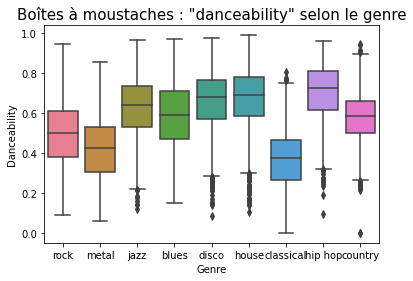

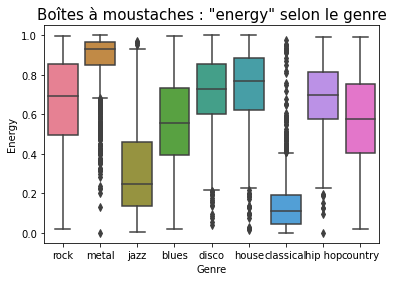

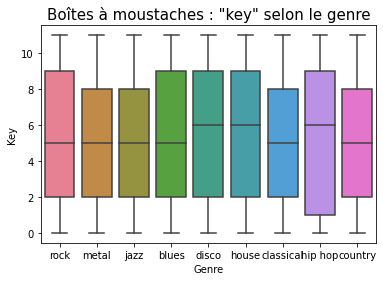

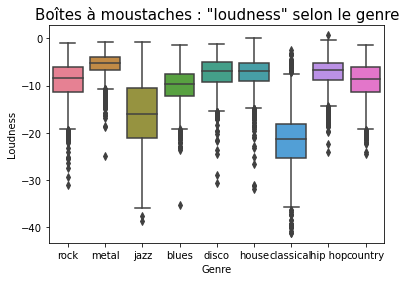

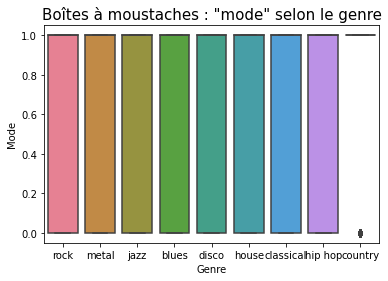

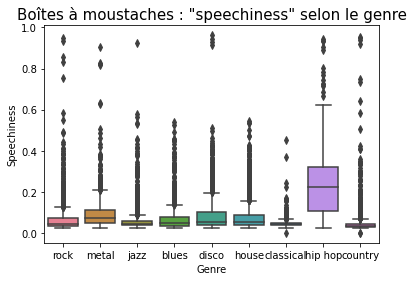

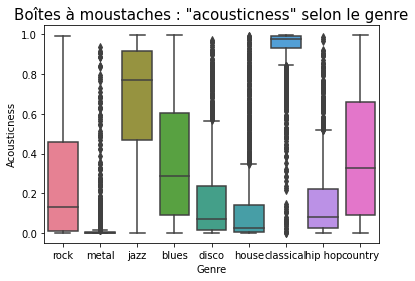

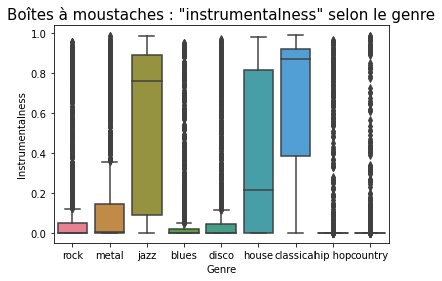

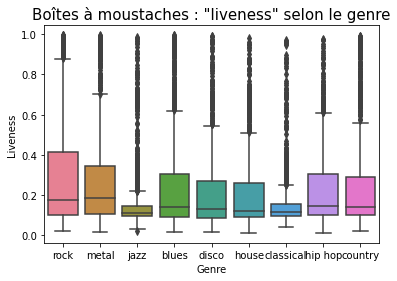

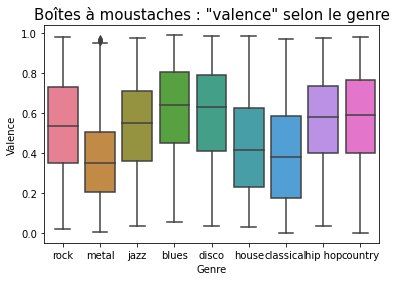

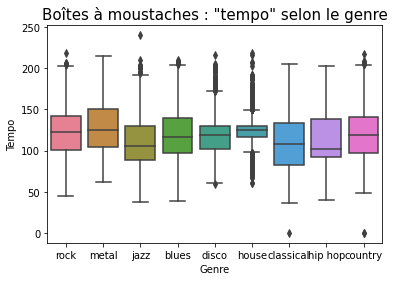

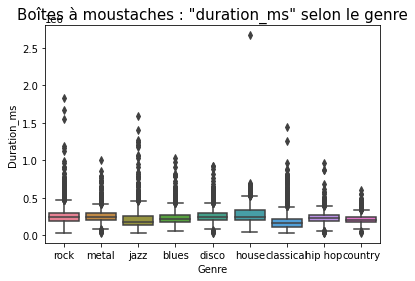

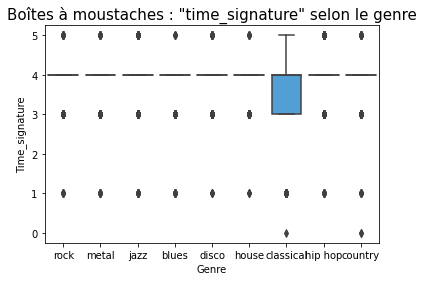

In [361]:
ax = sns.boxplot(y="danceability", x="genre", data=df_track, palette = 'husl')
plt.title('Boîtes à moustaches : "danceability" selon le genre', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 10)
plt.ylabel("Danceability", fontsize = 10)
plt.show()

ax = sns.boxplot(y="energy", x="genre", data=df_track, palette = 'husl')
plt.title('Boîtes à moustaches : "energy" selon le genre', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 10)
plt.ylabel("Energy", fontsize = 10)
plt.show()

ax = sns.boxplot(y="key", x="genre", data=df_track, palette = 'husl')
plt.title('Boîtes à moustaches : "key" selon le genre', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 10)
plt.ylabel("Key", fontsize = 10)
plt.show()

ax = sns.boxplot(y="loudness", x="genre", data=df_track, palette = 'husl')
plt.title('Boîtes à moustaches : "loudness" selon le genre', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 10)
plt.ylabel("Loudness", fontsize = 10)
plt.show()

#Pas pertinent de plot mode car ne prend que très peu de valeurs différentes.
ax = sns.boxplot(y="mode", x="genre", data=df_track, palette = 'husl')
plt.title('Boîtes à moustaches : "mode" selon le genre', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 10)
plt.ylabel("Mode", fontsize = 10)
plt.show()

ax = sns.boxplot(y="speechiness", x="genre", data=df_track, palette = 'husl')
plt.title('Boîtes à moustaches : "speechiness" selon le genre', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 10)
plt.ylabel("Speechiness", fontsize = 10)
plt.show()

ax = sns.boxplot(y="acousticness", x="genre", data=df_track, palette = 'husl')
plt.title('Boîtes à moustaches : "acousticness" selon le genre', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 10)
plt.ylabel("Acousticness", fontsize = 10)
plt.show()

ax = sns.boxplot(y="instrumentalness", x="genre", data=df_track, palette = 'husl')
plt.title('Boîtes à moustaches : "instrumentalness" selon le genre', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 10)
plt.ylabel("Instrumentalness", fontsize = 10)
plt.show()

ax = sns.boxplot(y="liveness", x="genre", data=df_track, palette = 'husl')
plt.title('Boîtes à moustaches : "liveness" selon le genre', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 10)
plt.ylabel("Liveness", fontsize = 10)
plt.show()

ax = sns.boxplot(y="valence", x="genre", data=df_track, palette = 'husl')
plt.title('Boîtes à moustaches : "valence" selon le genre', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 10)
plt.ylabel("Valence", fontsize = 10)
plt.show()

ax = sns.boxplot(y="tempo", x="genre", data=df_track, palette = 'husl')
plt.title('Boîtes à moustaches : "tempo" selon le genre', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 10)
plt.ylabel("Tempo", fontsize = 10)
plt.show()

ax = sns.boxplot(y="duration_ms", x="genre", data=df_track, palette = 'husl')
plt.title('Boîtes à moustaches : "duration_ms" selon le genre',fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 10)
plt.ylabel("Duration_ms", fontsize = 10)
plt.show()

ax = sns.boxplot(y="time_signature", x="genre", data=df_track, palette = 'husl')
plt.title('Boîtes à moustaches : "time_signature" selon le genre', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 10)
plt.ylabel("Time_signature", fontsize = 10)
plt.show()

Certaines boîtes montrent des dispersions très différentes en fonction du genre notamment l'energy, la danceability, l'instrumentalness, ou encore l'accousticness, tandis que d'autres caractéristiques ne diffèrent que très peu, par exemple les features key, mode ou time_signature. 

Concernant ces features, on pouvait s'y attendre car ce ne sont pas des caractéristiques donnant une "note" entre 0 et 1 comme beaucoup d'autres, mais des indicateurs discrets ne prenant que peu de valeurs différentes.

D'autres caractéristiques qui auraient pu montrer une dispersion très différente affichent une distribution finalement assez similaire selon le genre, comme le tempo, liveness, ou encore la duration_ms, ce qu'il est intéressant de noter. 

Les features qui ne diffèrent qu'assez peu en fonction du genre ne permettent pas réellement de distinguer un genre d'un autre : ces features ne semblent donc pas ou peu pertinentes pour la prédiction. On pourra ainsi par la suite éventuellement supprimer ces features.

### 2. 2. 2. Distribution des features de df_timbres et df_pitches pour chaque genre

plot les df pitches 
plot les df timbres

## 2. 3 Union des bases de données

Nous allons travailler sur différentes bases afin de déterminer laquelle contient les features les plus pertinentes et permet de réaliser une prédiction la plus performante possible. On considère pour cela la base df_track uniquement, df_total c'est-à-dire les trois bases fusionnées ainsi que la base df_track fusionnées avec les statistiques extraites des bases pitches et timbres.

### 2. 3. 1. Restructuration des colonnes

Les pitches et timbres se lisent par groupe de 12 : il s'agit d'un vecteur de 12 coefficients. 
Il est donc pertinent de comparer les pitches entre elles ou timbres entre eux coefficient par coefficient.
On peut également calculer les statistiques du vecteur (chromagramme, fonction de timbre), pour nous donner des informations sur le chromagramme/la fonction de timbre "type" selon le genre.

Pour plus de clarté, on va renommer les colonnes des dataframes timbres et pitches. On aura les 125 premiers chromagrammes de chaque chanson, un chromagramme correspondant aux 12 colonnes commençant par pitchk avec $k \in [[0,124]]$. De même pour les fonctions de timbres.

In [3]:
newCols = ["pitch0_idx" + str(k) for k in range(1,13)]
for pitchIdx in range(1,125):
    newCols.extend([("pitch%d_idx" % pitchIdx) + str(k) for k in range(1,13)])
newCols.extend(['genre'])

df_pitches.columns = newCols
#df_pitches

In [4]:
newCols = ["timbre0_idx" + str(k) for k in range(1,13)]
for timbreIdx in range(1,125):
    newCols.extend([("timbre%d_idx" % timbreIdx) + str(k) for k in range(1,13)])
newCols.extend(['genre'])
df_timbres.columns = newCols
#df_timbres

On rassemble ensuite des statistiques sur chaque dimension du chromagramme et de la fonction de timbre. On calcule la moyenne, l'écart-type, la skewness et la kurtosis pour chaque premier coefficient du chromagramme ou de la fonction de timbre, puis du second, etc jusqu'au 12ème. Cela permet d'avoir des informations sur la "distribution" des timbres et des pitches pour chaque morceaux.

In [5]:
df_pitches_reduced = pd.DataFrame(index = df_pitches.index)
for dimChroma in range(1,13):
    filteredCols = ["pitch%d_idx%d" % (pitchIdx, dimChroma) for pitchIdx in range(125)]
    filtered_df = df_pitches.filter(items = filteredCols).transpose()
    df_pitches_reduced['chroma%d_mean' % dimChroma] = filtered_df.mean()
    df_pitches_reduced['chroma%d_standard_deviation' % dimChroma] = filtered_df.std()
    df_pitches_reduced['chroma%d_skewness' % dimChroma] = filtered_df.skew()
    df_pitches_reduced['chroma%d_kurtosis' % dimChroma] = filtered_df.kurt()
#df_pitches_reduced

In [6]:
df_timbres_reduced = pd.DataFrame(index = df_timbres.index)
for dimTimbre in range(1,13):
    filteredCols = ["timbre%d_idx%d" % (timbreIdx, dimTimbre) for timbreIdx in range(125)]
    filtered_df = df_timbres.filter(items = filteredCols).transpose()
    df_timbres_reduced['timbre%d_mean' % dimTimbre] = filtered_df.mean()
    df_timbres_reduced['timbre%d_standard_deviation' % dimTimbre] = filtered_df.std()
    df_timbres_reduced['timbre%d_skewness' % dimTimbre] = filtered_df.skew()
    df_timbres_reduced['timbre%d_kurtosis' % dimTimbre] = filtered_df.kurt()
#df_timbres_reduced

### 2. 3. 2 Union des bases

#### Union des trois bases :

In [7]:
df_total = pd.merge(df_track, df_pitches.drop(columns='genre'), left_index=True, right_index=True)
df_total = pd.merge(df_total, df_timbres.drop(columns='genre'), left_index=True, right_index=True)
#df_total

print(df_total.shape)

(15399, 3016)


#### Union de df_track, df_timbres_reduced et df_pitches_reduced :

In [8]:
df_track_total = pd.merge(df_track, df_pitches_reduced, left_index=True, right_index=True)
df_track_total = pd.merge(df_track_total, df_timbres_reduced, left_index=True, right_index=True)
#df_track_total

print(df_track_total.shape)

(15399, 112)


Pour nos prédictions, nous travaillerons uniquement sur les bases df_track et df_track_total. En effet, df_total n'est pas pertinent : d'une part le nombre de features est bien trop important. D'autre part, ces features ne paraissent pas adaptées : la prédiction du genre d'un morceau ne dépend pas de chaque note ou timbre du morceaux pris indépendamment, mais plutôt d'informations sur le niveau global et la distribution globale des notes ou des timbres d'un morceau, qui peut éventuellement être liée à un genre précis. C'est d'ailleurs ce qui a motivé la création de df_track_total.

## 2. 4. Normalisation et réduction de dimension des données 

Simplifier notre modèle est essentiel pour obtenir le meilleur résultat possible : réduire le nombre de dimension de la base peut par exemple être intéressant. Comme mentionné précedemment, nous n'avons pas trouvé de corrélations fortes entre les features : nous pouvons ainsi réalisé une analyse en composante principaux (ACP). L'ACP perment en effet de déterminer la contribution relative de chaque feature des données à la variance entre les genres musicaux. Elle permet de calculer de nouveaux coefficients (combinaison des features) capturant le plus de variance possible afin de réduire le "nombre de dimensions" des données.

Cependant, comme l'ACP calcule la variance absolue, les features dont l'évantail de valeurs est larges vont surpasser les autres et biaiser l'algorithme. D'où une étape essentielle : normaliser les données grâce à la standardisation. 

### 2. 4. 1 Normalisation

#### Normalisation de df_track :

In [9]:
autoscaler = StandardScaler()

#On enlève les colonnes qui ne sont pas numériques (et donc qu'il n'est pas nécessaire de normaliser)
df_track_features = df_track.drop(['track_name', 'track_artists', 'genre'], axis=1)

#On normalise
normalized_features = autoscaler.fit_transform(df_track_features)

#On remplace les éventuels NaN par 0
normalized_features = np.nan_to_num(normalized_features)

#On vérifie qu'il n'y a plus de NaN
np.isnan(normalized_features).sum() 


0

In [10]:
#On reconstruit un "beau" DataFrame et on rajoute les colonnes qu'il n'était pas nécessaire de normaliser

normalized_df_track = pd.DataFrame(normalized_features, index=df_track_features.index, columns=df_track_features.columns)
normalized_df_track['track_name'] = df_track['track_name']
normalized_df_track['track_artists'] = df_track['track_artists']
normalized_df_track['genre'] = df_track['genre']

#normalized_df_track

#### Normalisation de df_total :

In [11]:
#On enlève les colonnes qui ne sont pas numériques (et donc qu'il n'est pas nécessaire de normaliser)
df_total_features = df_total.drop(['track_name', 'track_artists', 'genre'], axis=1)

#On normalise
normalized_df_total_features = autoscaler.fit_transform(df_total_features)

#On remplace les éventuels NaN par 0
normalized_df_total_features = np.nan_to_num(normalized_df_total_features)

#On vérifie qu'il n'y a plus de NaN
np.isnan(normalized_df_total_features).sum() 


0

In [12]:
#On reconstruit un "beau" DataFrame et on rajoute les colonnes qu'il n'était pas nécessaire de normaliser

normalized_df_total = pd.DataFrame(normalized_df_total_features, index=df_total_features.index, columns=df_total_features.columns)
normalized_df_total['track_name'] = df_total['track_name']
normalized_df_total['track_artists'] = df_total['track_artists']
normalized_df_total['genre'] = df_total['genre']

#normalized_df_total

In [13]:
normalized_pitches = normalized_df_total.iloc[:, 13:1513]
normalized_timbres = normalized_df_total.iloc[:, 1513:3013]

#### Normalisation de df_track_total

In [14]:
#On enlève les colonnes qui ne sont pas numériques (et donc qu'il n'est pas nécessaire de normaliser)
df_track_total_features = df_track_total.drop(['track_name', 'track_artists', 'genre'], axis=1)

#On normalise
normalized_df_track_total_features = autoscaler.fit_transform(df_track_total_features)

#On remplace les éventuels NaN par 0
normalized_df_track_total_features = np.nan_to_num(normalized_df_track_total_features)

#On vérifie qu'il n'y a plus de NaN
np.isnan(normalized_df_track_total_features).sum() 


0

In [15]:
#On reconstruit un "beau" DataFrame et on rajoute les colonnes qu'il n'était pas nécessaire de normaliser

normalized_df_track_total = pd.DataFrame(normalized_df_track_total_features, index=df_track_total_features.index, columns=df_track_total_features.columns)
normalized_df_track_total['track_name'] = df_track_total['track_name']
normalized_df_track_total['track_artists'] = df_track_total['track_artists']
normalized_df_track_total['genre'] = df_track_total['genre']

#normalized_df_track_total


#### Création de labels :

Pour faciliter les futurs calculs, on crée la colonne labels qui attribue un numéro à chaque genre musical :

In [16]:
genres_to_labels = {genre : idx for idx,genre in enumerate(normalized_df_track_total.genre.unique())}
labels_to_genres = {label : genre for genre, label in genres_to_labels.items()}

labels = [genres_to_labels[genre] for genre in normalized_df_track_total.genre]

normalized_df_track_total['labels'] = labels

normalized_df_track['labels'] = labels

print(labels_to_genres)

{0: 'rock', 1: 'metal', 2: 'jazz', 3: 'blues', 4: 'disco', 5: 'house', 6: 'classical', 7: 'hip hop', 8: 'country'}


### 2. 4. 2. ACP sur les données normalisées

#### ACP sur normalized_pitches et normalized_timbres

On ne s'attend pas à obtenir des résultats satisfaisants, mais plutôt à démontrer que ces features sont insuffisantes à capture la variance entre les différents genres musicaux.

Variance: [0.06732918 0.02412091 0.01989981 0.01950013 0.01662084 0.0149851
 0.01389151 0.0113941  0.01030949 0.00976489]
Variance totale: 0.20781595737617434


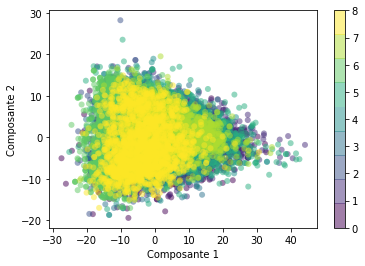

In [17]:
pca = PCA(n_components=10)

pca_pitches = pca.fit_transform(normalized_pitches)

print('Variance:',pca.explained_variance_ratio_)
print('Variance totale:',pca.explained_variance_ratio_.sum())

plt.scatter(pca_pitches[:, 0], pca_pitches[:, 1],
            c=normalized_df_track_total.labels, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('viridis', 9))
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
plt.colorbar();

Variance: [0.09346474 0.04982452 0.02903098 0.02479168 0.02002776 0.01762173
 0.01474863 0.01439471 0.01209626 0.00986374]
Variance totale: 0.28586474868403644


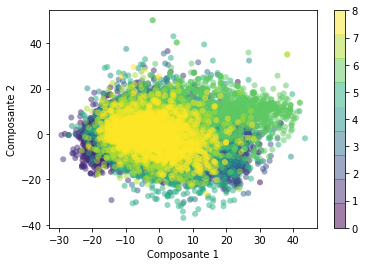

In [18]:
pca = PCA(n_components=10)

pca_timbres = pca.fit_transform(normalized_timbres)

print('Variance:',pca.explained_variance_ratio_)
print('Variance totale:',pca.explained_variance_ratio_.sum())

plt.scatter(pca_timbres[:, 0], pca_timbres[:, 1],
            c=normalized_df_track_total.labels, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('viridis', 9))
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
plt.colorbar();

On remarque que ces features ne capturent que très peu de variance : entre 20 et 30% pour les dix premières composantes. Il ne paraît donc pas possible de réaliser une réduction de dimension puisqu'aucune composante ne semble se dégager des autres. Or, la taille des deux datasets est très conséquente : ces derniers ne paraissent donc pas pertinent pour nos modèles de prédictions.

Lorsqu'on essaie de projeter les données sur l'espace formé par les deux premières composantes, les genres se superposent : on ne distingue qu'un amat de points dont aucun des genres ne semblent se dégager. On ne semble pas obtenir une classification évidente à l'aide de ces features. 

On se penche sur les deux autres bases de données, qui semblent plus adapter à décrire les genres musicaux des morceaux.

#### ACP sur df_track

Variance: [0.25262265 0.12472353 0.0926487  0.08207891 0.07992753 0.06859336
 0.06710432]
Variance totale: 0.7676990077491763


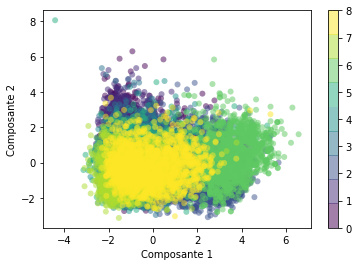

In [19]:
pca = PCA(n_components=7)

pca_df_track = pca.fit_transform(normalized_df_track.drop(['genre', 'track_artists', 'track_name', 'labels'], axis = 1))

print('Variance:',pca.explained_variance_ratio_)
print('Variance totale:',pca.explained_variance_ratio_.sum())

plt.scatter(pca_df_track[:, 0], pca_df_track[:, 1],
            c=normalized_df_track_total.labels, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('viridis', 9))
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
plt.colorbar();

Les sept premières composantes capturent une partie significative de la variance : 77%.
Les deux premières composantes capturent près de 40% de la variance, ce qui est déjà intéressant. En affichant la projection des features sur les deux premières composante de l'ACP, on distingue encore un amat de points mais certains clusters de genres semblent s'en dégager quelque peu.  

#### ACP sur df_track_total sans les features de df_track 

On se concentre uniquement sur les statistiques des pitches et des timbres pour évaluer leur capacité à distinguer différents genres musicaux, et ainsi évaluer ce qu'elles pourraient ajouter aux features de base.

Variance: [0.12565279 0.09121769 0.06323063 0.05118413 0.03369021 0.03017814
 0.02856491 0.02744492 0.02660605 0.02416754]
Variance totale: 0.50193701694813


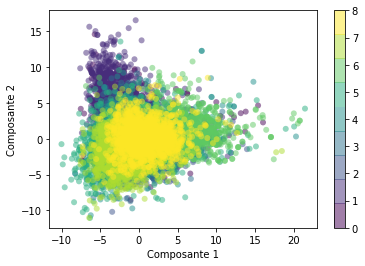

In [20]:
pca = PCA(n_components=10)

pca_df_track_total = pca.fit_transform(normalized_df_track_total.iloc[:,13:109])

print('Variance:',pca.explained_variance_ratio_)
print('Variance totale:',pca.explained_variance_ratio_.sum())

plt.scatter(pca_df_track_total[:, 0], pca_df_track_total[:, 1],
            c=normalized_df_track_total.labels, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('viridis', 9))
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
plt.colorbar();

On voit que les dix premières composantes de l'ACP n'expliquent que 50% de la variance à elles seules, ce qui n'est pas beaucoup, mais reste meilleur que les timbres et pitches considérées indépendamment.

Lorsqu'on projette les données sur l'espace formé par les deux premières composantes, les genres se superposent à nouveau beaucoup même si certains groupes se dégagent quelque peu de la masse.

### 2. 4. 3 Réduction de dimension des dataframes

A partir des ACP réalisées, on peut appliquer une réduction de dimension à df_track_total afin de simplifier le modèle et d'éviter les temps de calculs trop longs. 

Il ne paraît pas nécessaire de réduire la dimension de df_track, qui ne contient que 9 features utiles à la prédiction : cela constitue déjà un modèle simple et il ne paraît pas pertinent de réduire les dimensions (ce qui impliquerait de capturer moins de variance et donc pourrait amener parfois des prédictions moins performantes).

Au vu de la variance capturée par les coefficients, et toujours dans l'objectif de simplifier le modèle (donc de réduire le nombre de dimension de façon significative) on choisit de garder les onze premières features contenant des statistiques pitches et timbres (qui contenait à la base une centaine de composantes) afin de capturer 50% de la variance. On forme normalized_df_track_total_reduced en rajoutant à ces 11 features celles du df_track.


In [21]:
pca = PCA(n_components=5)

pca_df_track = pca.fit(normalized_df_track.drop(['track_artists', 'track_name', 'genre','labels'], axis = 1))

normalized_df_track_reduced = pca.transform(normalized_df_track.drop(columns = ['genre','track_artists','track_name', 'labels'], axis=1))

print(normalized_df_track_reduced.shape)

#normalized_df_track_reduced

(15399, 5)


In [22]:
pca = PCA(n_components=11)

pca_df_track_total = pca.fit_transform(normalized_df_track_total.iloc[:,13:109]) 
normalized_df_track_total_reduced = pca.transform(normalized_df_track_total.iloc[:,13:109])

normalized_df_track_total_reduced = pd.DataFrame(normalized_df_track_total_reduced)
normalized_df_track_total_reduced['id'] = normalized_df_track.index
normalized_df_track_total_reduced = normalized_df_track_total_reduced.set_index(['id'])

normalized_df_track_total_reduced = pd.merge(normalized_df_track_total_reduced, normalized_df_track, left_index=True, right_index=True)

normalized_df_track_total_reduced = normalized_df_track_total_reduced.drop(['track_name','track_artists','genre','labels'],axis=1)

list(normalized_df_track_total_reduced.columns)


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms',
 'time_signature']

# 2. Modèles de prédiction de machine learning

Nous avons sélectionné cinq modèles d'apprentissage supervisé :

- **KNN**


- **SGDC Classifier**


- **Decision Tree Classifier**


- **Random Forest Regression**


- **XG Booster**

## 2. 1. Séparation en base de train et test

#### Pour normalized_df_track :

In [23]:
X_train, X_test, y_train, y_test = train_test_split(normalized_df_track.drop(['track_artists', 'track_name', 'genre','labels'], axis = 1), labels, random_state = 42)

#### Pour normalized_df_track_total :

In [24]:
X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(normalized_df_track_total.drop(['track_artists', 'track_name', 'genre','labels'], axis = 1), labels, random_state = 42)

#### Pour normalized_df_track_total_reduced :

In [25]:
X_train_total_r, X_test_total_r, y_train_total_r, y_test_total_r = train_test_split(normalized_df_track_total_reduced, labels, random_state = 42)

On pourra ainsi comparer les performances des différentes bases selon les modèles de prédiction, ainsi qu'utiliser la base "réduite" dedf_track_total dans le cas de modèle plus complexe, afin de réduire les temps de calculs.

## 2. 2. KNN

On commence par tester la performance de KNN, algorithme des k plus proches voisins. Il s'agit d'un des algorithmes d'apprentissage supervisé les plus simples et classiques, qui est utilisé pour résoudre des problèmes de classification. Il consiste à estimer le genre d'un morceau à partir des k échantillons d'apprentissage les plus proches de celui-ci.

On crée une fonction afin de déterminer quel nombre de 'voisins' considéré pour minimiser l'erreur.

#### KNN sur df_track :

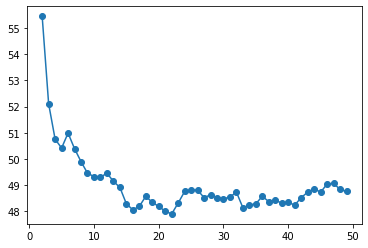

In [432]:
errors = []
for k in range(2,50):
    knn = neighbors.KNeighborsClassifier(k)
    errors.append(100*(1 - knn.fit(X_train, y_train).score(X_test, y_test)))
plt.plot(range(2,50), errors, 'o-')
plt.show()

Le meilleur nombre de voisins à considérer semble être k = 20.

In [439]:
knn = neighbors.KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, y_train)

print('Précision sur la base de train :', knn.score(X_train, y_train))

print('Précision sur la base de test :', knn.score(X_test, y_test))

Précision sur la base de train : 0.572084163131007
Précision sur la base de test : 0.5181818181818182


Le modèle n'overfit pas (surapprentissage sur les données train) : c'est pour ça qu'on affiche la précision sur la base de train, car si celle si est bien plus grande que pour la base de test, le modèle overfit. 

On a une précision de 52% environ ce qui est presque 5 fois meilleur que si on attribuait les genres musicaux au hasard (une chance sur neuf).

Ce modèle simple offre donc déjà des résultats intéressant, qui plus est sur une base de données non enrichie par les statistiques de pitches et timbres.


#### KNN sur df_track_total :

Le modèle restant assez simple, on peut considérer df_track_total au lieu de son alternative réduite.

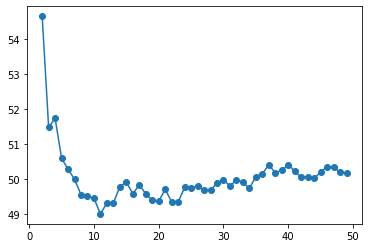

In [435]:
errors = []
for k in range(2,50):
    knn = neighbors.KNeighborsClassifier(k)
    errors.append(100*(1 - knn.fit(X_train_total, y_train_total).score(X_test_total, y_test_total)))
plt.plot(range(2,50), errors, 'o-')
plt.show()

Le meilleur nombre de voisins à considérer semble être k = 11

In [440]:
knn = neighbors.KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train_total, y_train_total)

print('Précision sur la base de train :', knn.score(X_train_total, y_train_total))

print('Précision sur la base de test :', knn.score(X_test_total, y_test_total))

Précision sur la base de train : 0.593211533466101
Précision sur la base de test : 0.5098701298701299


Le modèle n'overfit pas (surapprentissage sur les données train). On a une précision de 51% environ, donc du même ordre que précèdemment. L'ajout des statistiques de ptiches et timbres n'améliore donc pas sensiblement notre prédiction dans le cadre de ce modèle.

## 2. 3. Classification Linéaire

On utilise un module de classification proposé par sklearn : la descente de gradient stochastique. Il s'agit d'un modèle linéaire simple qui ne devrait pas offrir d'excellents résultats, mais il ne risque pas d'overfitter.
L’overfitting correspond en effet a un phénomène de surapprentissage de l'algorithme qui apprend "trop précisément" sur les données de la base de train et manque de capacité de généralisation. 

#### Classification linéaire pour df_track :

In [475]:
sgd_normalized_df_track = SGDClassifier(loss = 'log').fit(X_train, y_train) 

print('Précision sur la base de train :', accuracy_score(y_train, sgd_normalized_df_track.predict(X_train)))
print('Précision sur la base de test :', accuracy_score(y_test, sgd_normalized_df_track.predict(X_test)))


Précision sur la base de train : 0.5164083470430341
Précision sur la base de test : 0.5051948051948052


[]

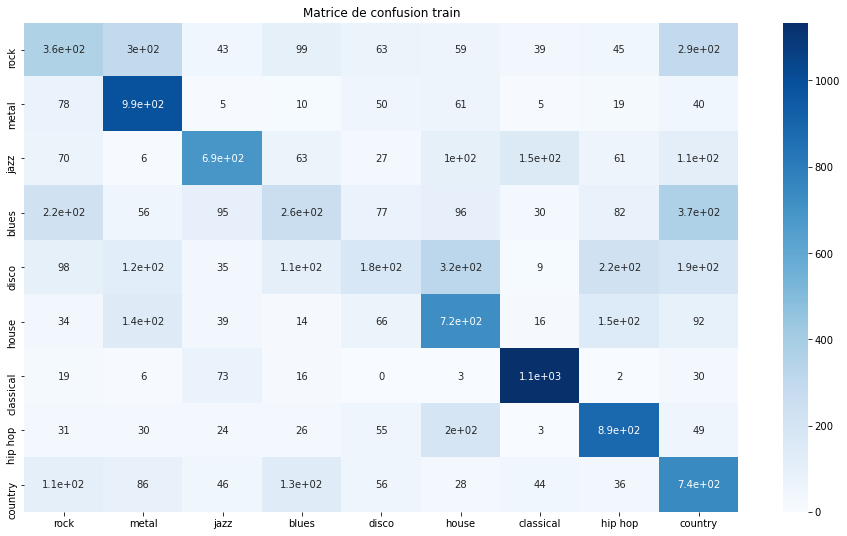

In [479]:
confusion_matr = confusion_matrix(y_train, sgd_normalized_df_track.predict(X_train)) 
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = labels_to_genres.values(),
            yticklabels = labels_to_genres.values())
plt.title("Matrice de confusion train")
plt.plot()

[]

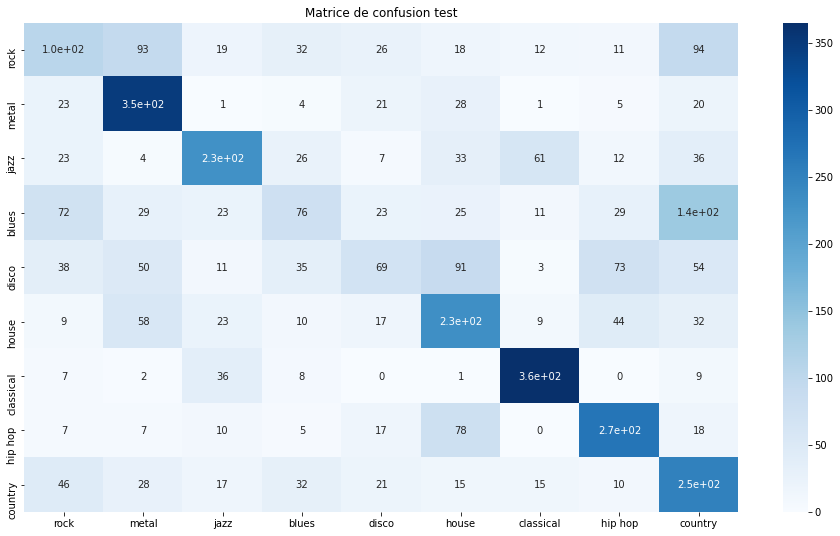

In [478]:
confusion_matr = confusion_matrix(y_test, sgd_normalized_df_track.predict(X_test)) 
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = labels_to_genres.values(),
            yticklabels = labels_to_genres.values())
plt.title("Matrice de confusion test")
plt.plot()

Le modèle n'overfit pas (surapprentissage sur les données train). On a une précision de 51% environ ce qui est du même ordre qu'avec le modèle KNN. Ce modèle n'améliore donc pas les performances de prédiction à partir de la base df_track.

En affichant les matrices de confusion, on remarque que les prédictions restent cohérentes entre train et test : les genres les mieux prédits sont le metal et le classique. Cela semble assez compréhensible : il s'agit de deux genres musicaux caractérisés par des attributs bien distincts des autres. La house, le hip-hop le country sont également assez bien prédits. 

Cependant beaucoup de morceaux "blues" sont prédits du genre "country" (d'ailleurs plus que d'actuels prédits "blues). De même, une partie des morceaux "rocks" sont prédits "metal" ou "country".

#### Classification linéaire pour df_track_total :

De même que précèdemment, le modèle restant assez simple, on peut considérer df_track_total au lieu de son alternative réduite.

In [480]:
sgd_normalized_df_track_total = SGDClassifier(loss = 'log').fit(X_train_total, y_train_total) 

print('Précision sur la base de train :', accuracy_score(y_train_total, sgd_normalized_df_track_total.predict(X_train_total)))

print('Précision sur la base de test :', accuracy_score(y_test_total, sgd_normalized_df_track_total.predict(X_test_total)))


Précision sur la base de train : 0.5807429214650619
Précision sur la base de test : 0.5641558441558442


[]

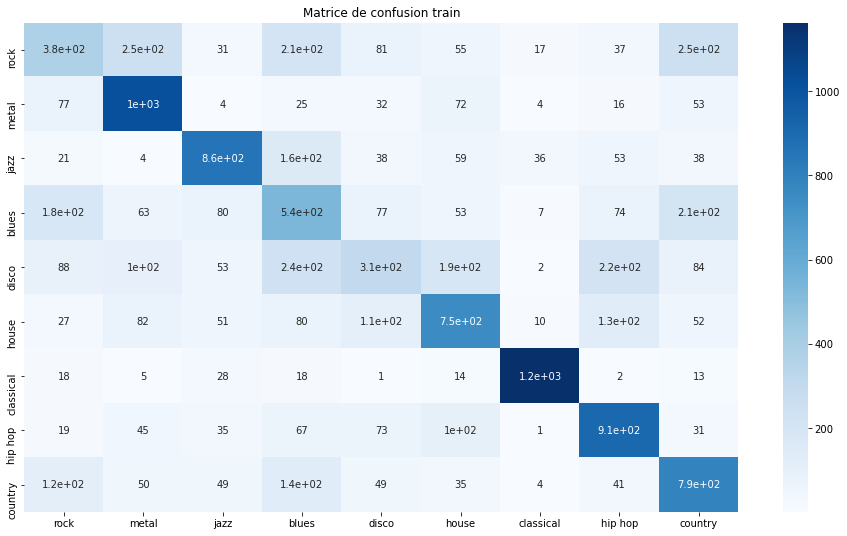

In [482]:
confusion_matr = confusion_matrix(y_train_total, sgd_normalized_df_track_total.predict(X_train_total)) 
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = labels_to_genres.values(),
            yticklabels = labels_to_genres.values())
plt.title("Matrice de confusion train")
plt.plot()

[]

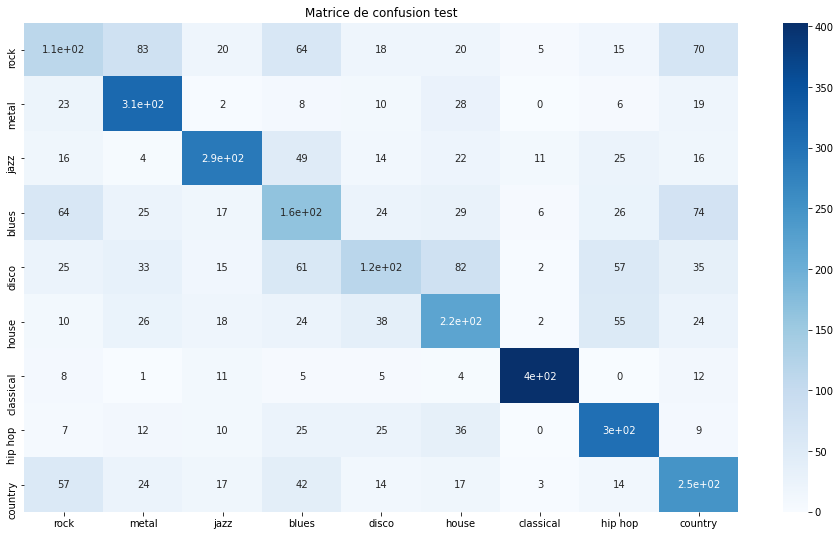

In [483]:
confusion_matr = confusion_matrix(y_test_total, sgd_normalized_df_track_total.predict(X_test_total)) 
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = labels_to_genres.values(),
            yticklabels = labels_to_genres.values())
plt.title("Matrice de confusion test")
plt.plot()

Le modèle n'overfit pas (surapprentissage sur les données train). On a une précision de presque 57% ce qui est meilleur qu'avec le modèle KNN. Les matrice de confusion, affiche des prédiction similaires à celle de df_track, avec un petit peu moins de confusion avec le country pour les morceaux blues, et avec country et metal pour les morceaux rock.

Dans le cas de la classification linéaire, la base enrichie, plus complète, offre un meilleur taux de précision. Les features utilisées pour décrire les pitches et les timbres sont donc utiles pour la prédiction avec cet algorithme, ce qui n'était pas évident pour le KNN.

## 2. 4. Arbre de décision

Il s'agit de l'un des modèle les plus utilisé en machine learning, et il est adapté aux problèmes de classification. On construit un arbre de décision grâce aux données de train, qu'on utilise pour prédire les données test. Cependant ce modèle, bien plus complexe que les précédents, risque d'overfitter.

On cherche donc à évaluer et optimiser les perfomances des bases df_track et de la base réduite df_track_total_reduced.

#### Arbre de décision pour df_track :

In [25]:
tree_track = DecisionTreeClassifier().fit(X_train, y_train)

print('Précision sur la base de train :', accuracy_score(y_train, tree_track.predict(X_train)))
print('Précision sur la base de test :', accuracy_score(y_test, tree_track.predict(X_test)))

Précision sur la base de train : 0.9999134124166594
Précision sur la base de test : 0.47454545454545455


Comme prédit, le modèle overfit. On cherche à optimiser les hyperparamètres pour éviter ça :

In [486]:
parameters = {'max_depth':[4,5,6,7,8,9,10,15], 'min_samples_leaf':range(5,15),
              'min_samples_split':range(2,10)}
tree_track = DecisionTreeClassifier() 
tree_search_track = GridSearchCV(tree_track, parameters, scoring='neg_mean_squared_error', cv=10, n_jobs=-1, verbose=1)
tree_search_track.fit(X_train, y_train)
tree_search_track = tree_search_track.best_estimator_    # On récupère le "meilleur" modèle

Fitting 10 folds for each of 640 candidates, totalling 6400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 6400 out of 6400 | elapsed:  8.4min finished


In [488]:
print(tree_search_track)
print('Précision sur la base de train :', accuracy_score(y_train, tree_search_track.predict(X_train)))
print('Précision sur la base de test :', accuracy_score(y_test, tree_search_track.predict(X_test)))

DecisionTreeClassifier(max_depth=7, min_samples_leaf=5, min_samples_split=6)
Précision sur la base de train : 0.5282708459606892
Précision sur la base de test : 0.48883116883116884


[]

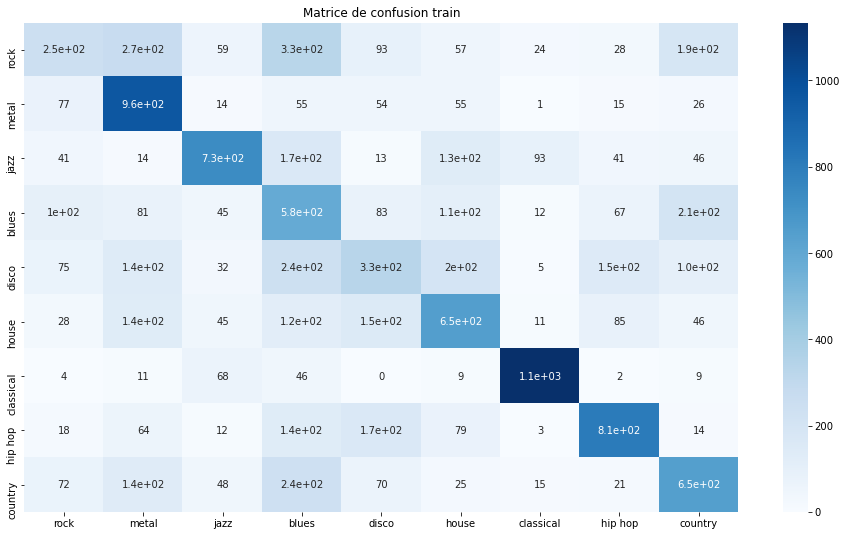

In [494]:
confusion_matr = confusion_matrix(y_train, tree_search_track.predict(X_train)) 
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = labels_to_genres.values(),
            yticklabels = labels_to_genres.values())
plt.title("Matrice de confusion train")
plt.plot()

[]

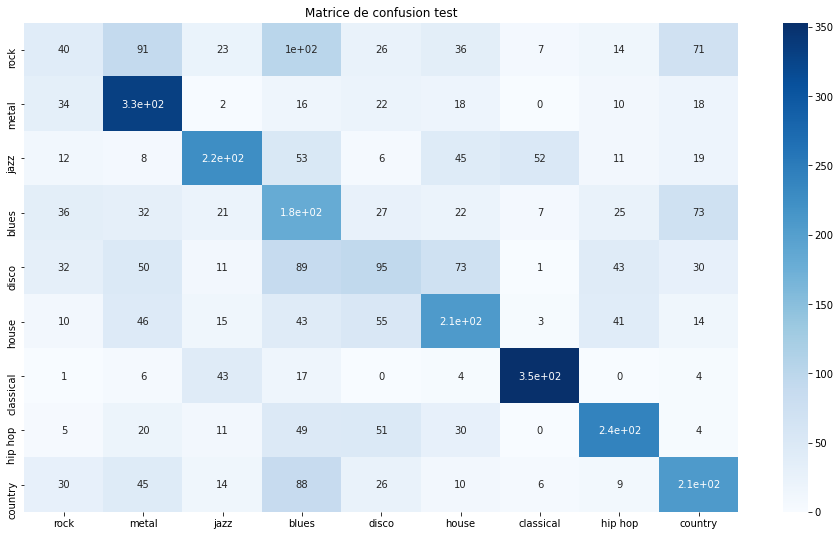

In [495]:
confusion_matr = confusion_matrix(y_test, tree_search_track.predict(X_test)) 
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = labels_to_genres.values(),
            yticklabels = labels_to_genres.values())
plt.title("Matrice de confusion test")
plt.plot()

Notre précision est de 49%, ce qui est similaire au modèle de classification linéaire pour le df_track. On remarque aussi que les prédictions affichées par les matrices de confusions sont semblables : toujours une meilleure prédiction des morceaux metal et classical, puis hip-hop, country et house. 

Le modèle ne semble également pas suffisant à régler les problèmes de confusion : cette fois beaucoup de morceaux rock sont attribué au genre blues. Le country est également à nouveau souvent attribué au genre blues. Le genre blues semble d'ailleurs globalement assez peu distinct des autres genres, car souvent attribué à tort.

#### Arbre de décision pour df_track_total_reduced :

In [491]:
tree_track_total = DecisionTreeClassifier().fit(X_train_total_r, y_train_total_r)

print('Précision sur la base de train :', accuracy_score(y_train_total_r, tree_track_total.predict(X_train_total_r)))
print('Précision sur la base de test :', accuracy_score(y_test_total_r, tree_track_total.predict(X_test_total_r)))

Précision sur la base de train : 1.0
Précision sur la base de test : 0.47584415584415585


Comme prédit, le modèle overfit. On cherche à optimiser les hyperparamètres pour éviter ça :

In [492]:
parameters = {'max_depth':[4,5,6,7,8,9,10,15], 'min_samples_leaf':range(5,15),
              'min_samples_split':range(2,10)}
tree_track_total = DecisionTreeClassifier() 
tree_search_track_total = GridSearchCV(tree_track_total, parameters, scoring='neg_mean_squared_error', cv=10, n_jobs=-1, verbose=1)
tree_search_track_total.fit(X_train_total_r, y_train_total_r)
tree_search_track_total = tree_search_track_total.best_estimator_    # On récupère le "meilleur" modèle

Fitting 10 folds for each of 640 candidates, totalling 6400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 6400 out of 6400 | elapsed: 11.4min finished


In [493]:
print(tree_search_track_total)
print('Précision sur la base de train :', accuracy_score(y_train_total_r, tree_search_track_total.predict(X_train_total_r)))
print('Précision sur la base de test :', accuracy_score(y_test_total_r, tree_search_track_total.predict(X_test_total_r)))

DecisionTreeClassifier(max_depth=9, min_samples_leaf=5, min_samples_split=3)
Précision sur la base de train : 0.5761537795480128
Précision sur la base de test : 0.509090909090909


[]

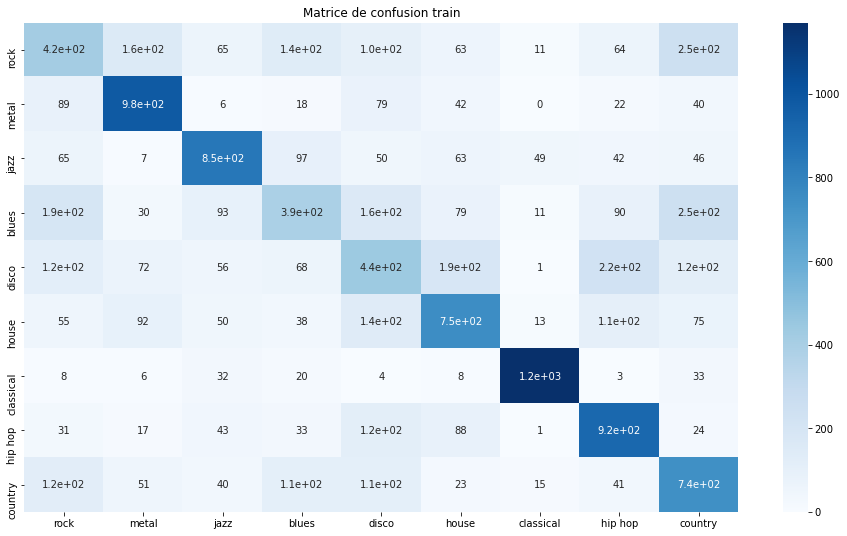

In [497]:
confusion_matr = confusion_matrix(y_train_total_r, tree_search_track_total.predict(X_train_total_r)) 
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = labels_to_genres.values(),
            yticklabels = labels_to_genres.values())
plt.title("Matrice de confusion train")
plt.plot()

[]

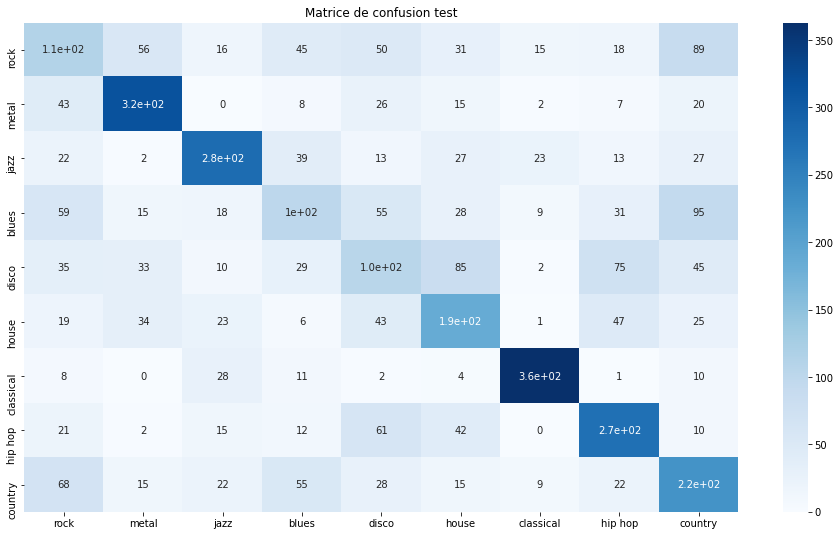

In [498]:
confusion_matr = confusion_matrix(y_test_total_r, tree_search_track_total.predict(X_test_total_r)) 
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = labels_to_genres.values(),
            yticklabels = labels_to_genres.values())
plt.title("Matrice de confusion test")
plt.plot()

Le modèle n'overfit pas (surapprentissage sur les données train). Comme pour le modèle de classification linéaire, la df_track_total_reduced offre de meilleurs résultats que le df_track uniquement.
Cependant les performances sont du même ordre que pour le KNN : une précision d'environ 51% pour le df_track_total_reduced.

Au niveau des matrices de confusion, elles sont comparables aux modèles précédents, même si l'ajout des statistiques sur les pitches et timbres semble permettre de mieux prédire le rock (moins attribués à tort à d'autres genres, notamment au blues). Le blues semble également légèrement moins attribués à tort.

Le modèle de classification linéaire reste donc un peu meilleur.

## 2. 5. Random forest

Pour aller plus loin, nous pouvons étudier l'apport d'une Random Forest, qui constitue une version supérieure des arbres de décision. Ce modèle étant encore plus complexe, nous l'appliquerons donc aux bases df_track et df_track_total_reduced. On peut attendre des résultats plus performants que pour l'arbre de décision, avec toujours de meilleures performance pour la deuxième base, enrichie.

#### Random forest pour df_track :

In [499]:
rfc_track = RandomForestClassifier().fit(X_train, y_train)

print('Précision sur la base de train :', accuracy_score(y_train, rfc_track.predict(X_train)))
print('Précision sur la base de test :', accuracy_score(y_test, rfc_track.predict(X_test)))

Précision sur la base de train : 0.9999134124166594
Précision sur la base de test : 0.5888311688311688


On overfit également avec ce modèle, on optimise donc les hyperparamètres :

In [502]:
parameters = {'max_depth':[2,3,4,5,7,8], 'min_samples_leaf':[2,3,4,5,6],
              'max_features':["auto"], 'n_estimators':[20,30,40,50]}
rfc_track = RandomForestClassifier()
rf_search_track = GridSearchCV(rfc_track, parameters, scoring='neg_mean_squared_error', cv=10, n_jobs=-1, verbose=1)
rf_search_track.fit(X_train, y_train)
rf_search_track = rf_search_track.best_estimator_

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  5.9min finished


In [503]:
print(rf_search_track)
print('Précision sur la base de train :', accuracy_score(y_train, rf_search_track.predict(X_train)))
print('Précision sur la base de test :', accuracy_score(y_test, rf_search_track.predict(X_test)))

RandomForestClassifier(max_depth=8, min_samples_leaf=6, n_estimators=40)
Précision sur la base de train : 0.6163304182180276
Précision sur la base de test : 0.5423376623376623


[]

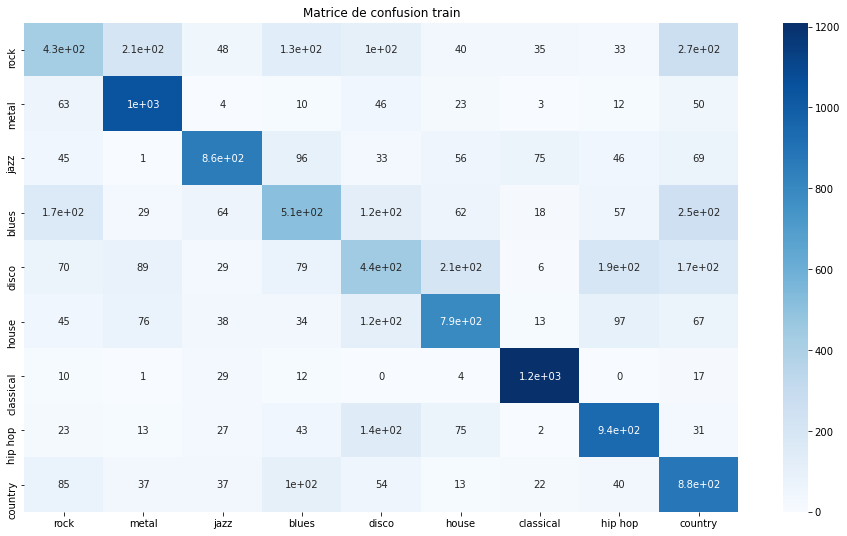

In [504]:
confusion_matr = confusion_matrix(y_train, rf_search_track.predict(X_train)) 
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = labels_to_genres.values(),
            yticklabels = labels_to_genres.values())
plt.title("Matrice de confusion train")
plt.plot()

[]

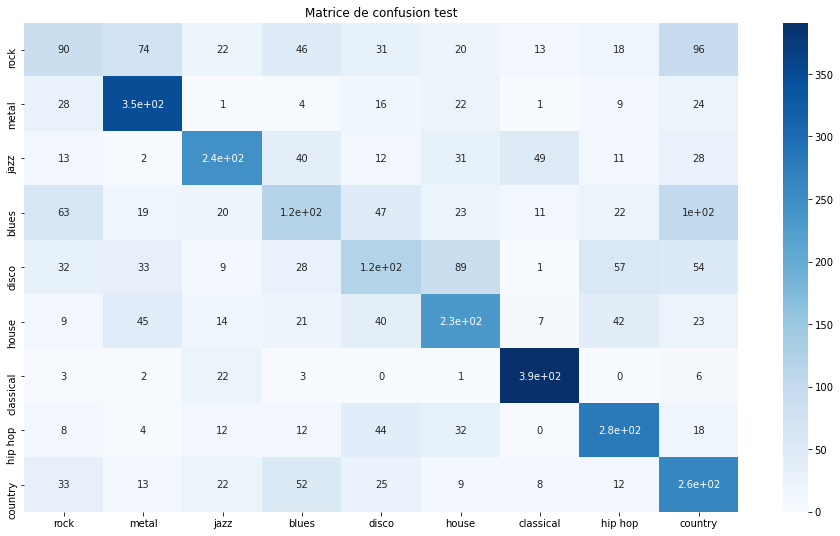

In [505]:
confusion_matr = confusion_matrix(y_test, rf_search_track.predict(X_test)) 
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = labels_to_genres.values(),
            yticklabels = labels_to_genres.values())
plt.title("Matrice de confusion test")
plt.plot()

Les résultats sont cohérents avec ce qu'on attendait : on obtient des résultats légèrement meilleurs qu'avec l'arbre de décision : environ 54% de précision, ce qui constitue le meilleur résultat de prédiction à partir de la base df_track jusqu'alors. 

On constate par les matrices de confusion que le problème du rock attribué au metal est au country n'est toujours pas résolu. Il peut également être intéressant de noter que les morceaux blues sont aussi en grande partie attribués au genre country (autant qu'actuellement attribués au blues), ce qui est un problème qu'on rencontrait avant mais de façon plus minime.

#### Random forest pour df_track_total_reduced :

In [506]:
rfc_track_total = RandomForestClassifier().fit(X_train_total_r, y_train_total_r)

print('Précision sur la base de train :', accuracy_score(y_train_total_r, rfc_track_total.predict(X_train_total_r)))
print('Précision sur la base de test :', accuracy_score(y_test_total_r, rfc_track_total.predict(X_test_total_r)))

Précision sur la base de train : 1.0
Précision sur la base de test : 0.6090909090909091


On overfit, on optimise donc les hyperparamètres :

In [507]:
parameters = {'max_depth':[2,3,4,5,7,8], 'min_samples_leaf':[2,3,4,5,6],
              'max_features':["auto"], 'n_estimators':[20,30,40,50]}
rfc_track_total = RandomForestClassifier()
rf_search_track_total = GridSearchCV(rfc_track_total, parameters, scoring='neg_mean_squared_error', cv=10, n_jobs=-1, verbose=1)
rf_search_track_total.fit(X_train_total_r, y_train_total_r)
rf_search_track_total = rf_search_track_total.best_estimator_

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  5.6min finished


In [508]:
print(rf_search_track_total)
print('Précision sur la base de train :', accuracy_score(y_train_total_r, rf_search_track_total.predict(X_train_total_r)))
print('Précision sur la base de test :', accuracy_score(y_test_total_r, rf_search_track_total.predict(X_test_total_r)))

RandomForestClassifier(max_depth=8, min_samples_leaf=5, n_estimators=40)
Précision sur la base de train : 0.6311368949692614
Précision sur la base de test : 0.5602597402597402


[]

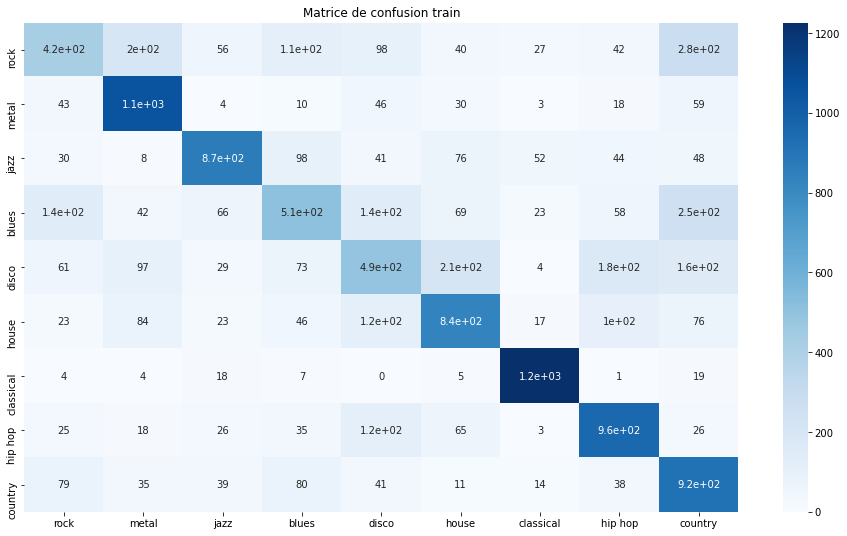

In [509]:
confusion_matr = confusion_matrix(y_train_total_r, rf_search_track_total.predict(X_train_total_r)) 
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = labels_to_genres.values(),
            yticklabels = labels_to_genres.values())
plt.title("Matrice de confusion train")
plt.plot()

[]

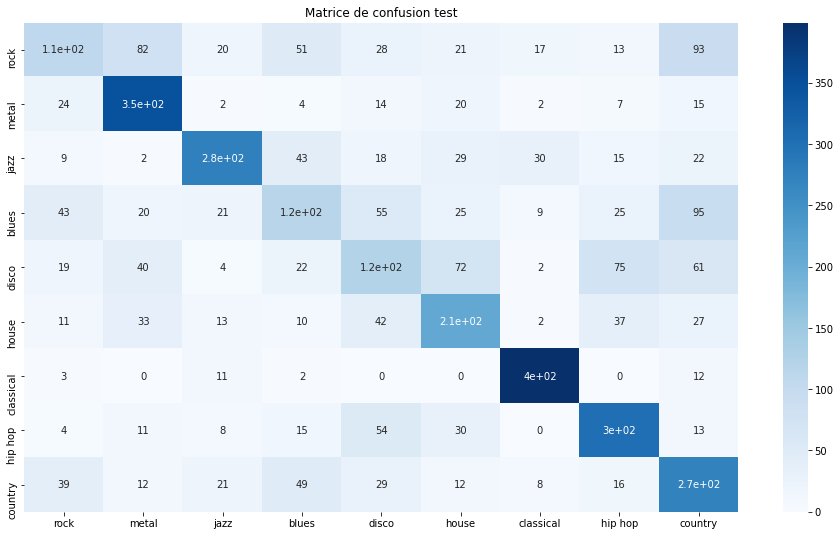

In [510]:
confusion_matr = confusion_matrix(y_test_total_r, rf_search_track_total.predict(X_test_total_r)) 
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = labels_to_genres.values(),
            yticklabels = labels_to_genres.values())
plt.title("Matrice de confusion test")
plt.plot()

Comme on l'attendait, nous obtenons d'assez bon résultats : 56% de précision, de l'ordre du classificateur linéaire. Les résultats sont encore une fois meilleures avec la base enrichie. On peut d'ailleurs penser que ce modèle est en théorie "plus adapté" a un problème de classification comme celui-ci que le classificateur linéaire.

On rencontre exactement les mêmes problèmes de confusion qu'avec la prédiction sur df_track.

## 2. 6. XG Boost

On choisit finalement d'évaluer les performances du modèle XGBoost : le Boosting de Gradient. Il s'agit d'un algorithme d’apprentissage supervisé qui combine les résultats d’un ensemble de modèles plus simples afin de fournir une meilleur prédiction que s'ils étaient considéré chacun indépendamment.
On peut donc s'attendre à des résultats intéressants pour ce modèle.

#### XG Boost sur le df_track :

In [27]:
param = {
    'max_depth': 5,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'num_class': 9}

xgb_track = xgb.XGBClassifier(num_boost_round=30, early_stopping_rounds=5,param = param)
xgb_track.fit(X_train, y_train)

XGBClassifier(early_stopping_rounds=5, num_boost_round=30,
              objective='multi:softprob',
              param={'eta': 0.3, 'max_depth': 5, 'num_class': 9,
                     'objective': 'multi:softprob', 'silent': 1})

In [58]:
xgb_track = XGBClassifier(n_estimators=500,learning_rate=0.05)
xgb_track.fit(X_train, y_train)
print('Précision sur la base de train :', accuracy_score(y_train, xgb_track.predict(X_train)))
print('Précision sur la base de test :', accuracy_score(y_test, xgb_track.predict(X_test)))

Précision sur la base de train : 0.6766819638063901
Précision sur la base de test : 0.5794805194805195


On overfit pas mais on peut essayer d'optimiser les paramètres :

In [60]:
parameters = {'n_estimators':[300,400,500,600], 'learning_rate':[0.05,0.1]}
xgb_track = XGBClassifier()
xgb_search_track = GridSearchCV(xgb_track, parameters, scoring='neg_mean_squared_error', cv=10, n_jobs=-1, verbose=1)
xgb_search_track.fit(X_train, y_train)
xgb_search_track = xgb_search_track.best_estimator_

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 40.1min finished


In [62]:
print(xgb_search_track)

XGBClassifier(learning_rate=0.05, n_estimators=600, objective='multi:softprob')


In [64]:
xgb_track = XGBClassifier(n_estimators=600,learning_rate=0.05)
xgb_track.fit(X_train, y_train)
print('Précision sur la base de train :', accuracy_score(y_train, xgb_track.predict(X_train)))
print('Précision sur la base de test :', accuracy_score(y_test, xgb_track.predict(X_test)))

Précision sur la base de train : 0.6929604294744134
Précision sur la base de test : 0.5828571428571429


[]

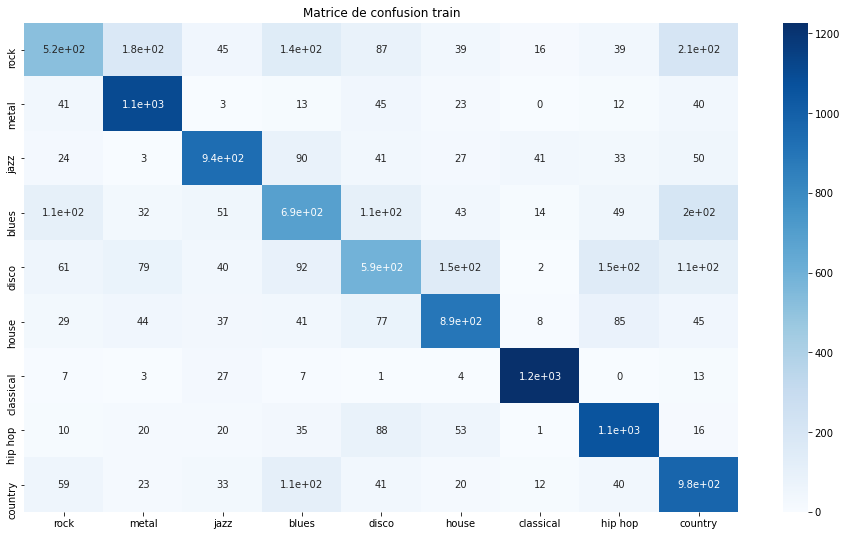

In [65]:
confusion_matr = confusion_matrix(y_train, xgb_track.predict(X_train)) 
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = labels_to_genres.values(),
            yticklabels = labels_to_genres.values())
plt.title("Matrice de confusion train")
plt.plot()

[]

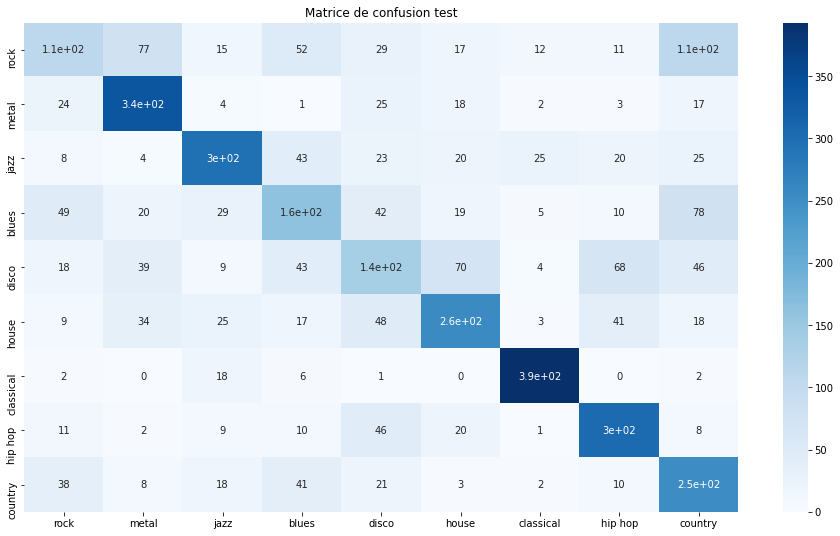

In [66]:
confusion_matr = confusion_matrix(y_test, xgb_track.predict(X_test)) 
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = labels_to_genres.values(),
            yticklabels = labels_to_genres.values())
plt.title("Matrice de confusion test")
plt.plot()

Le modèle n'overfit pas et on obtient des bons résultats bien que seulement légèrement supérieurs à un Random Forest : 58% de précision.
Les genres confondus restent les mêmes (notamment rock souvent mal attribué en country).

#### XG Boost sur le df_track_total_reduced :

In [48]:
xgb_track_total = xgb.XGBClassifier(num_boost_round=30, early_stopping_rounds=5,param = param)
xgb_track_total.fit(X_train_total_r, y_train_total_r)

XGBClassifier(early_stopping_rounds=5, num_boost_round=30,
              objective='multi:softprob',
              param={'eta': 0.3, 'max_depth': 5, 'num_class': 9,
                     'objective': 'multi:softprob', 'silent': 1})

In [49]:
print('Précision sur la base de train :', accuracy_score(y_train_total_r, xgb_track_total.predict(X_train_total_r)))
print('Précision sur la base de test :', accuracy_score(y_test_total_r, xgb_track_total.predict(X_test_total_r)))

Précision sur la base de train : 0.6501861633041822
Précision sur la base de test : 0.5805194805194805


[]

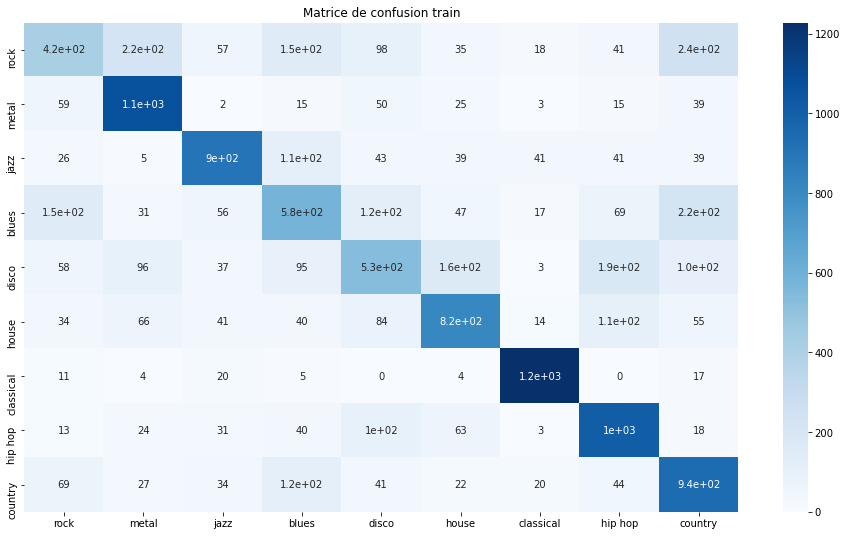

In [50]:
confusion_matr = confusion_matrix(y_train_total_r, xgb_track_total.predict(X_train_total_r)) 
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = labels_to_genres.values(),
            yticklabels = labels_to_genres.values())
plt.title("Matrice de confusion train")
plt.plot()

[]

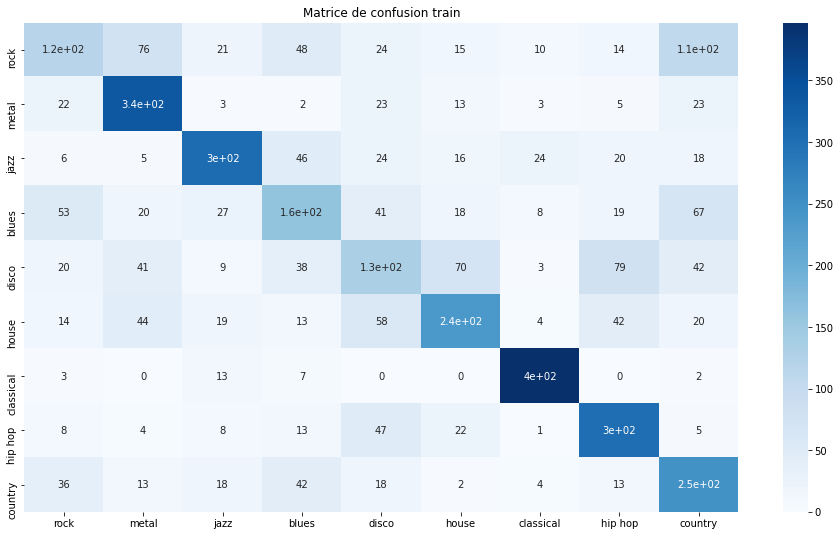

In [51]:
confusion_matr = confusion_matrix(y_test_total_r, xgb_track_total.predict(X_test_total_r)) 
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = labels_to_genres.values(),
            yticklabels = labels_to_genres.values())
plt.title("Matrice de confusion train")
plt.plot()

Les résultats en utilisant ce modèle ne sont finalement pas tellement meilleurs qu'un Random Forest : 58 % de précision, ce qui reste néanmoins la meilleure obtenue jusqu'alors.
Les matrices de confusion affichent des prédictions similaires aux autres modèles : morceaux rocks, blues et disco parfois mal attribués.

# 3. Modèle de prédiction de deep learning

Une autre approche à l'élaboration d'un modèle de prédiction consiste à voir les bases de pitches et de timbres comme des données temporelles : on a les 125 premiers chromagrammes et fonctions de timbres de chaque morceaux.
On pourrait à partir de cela tenter une approche de deep-learning et entraîner ces pitches et timbres sur un réseau de neurones. Par la suite à partir de ces bases entraînées, on pourrait rajouter les features de bases de df_track et évaluer les performances du modèle.
Cependant il s'agit d'une approche bien plus complexe et nous allons tout d'abord nous limiter à son élaboration sur les pitches, pour ensuite généraliser la méthode aux timbres si celle-ci donne des résultats satisfaisants.

## 3. 1.  Création du réseau de neurone

In [ ]:
normalized_spot_features = normalized_df_track.iloc[:, :13]

X = pd.merge(df_pitches, normalized_spot_features, on=df_pitches.index)

label_enc = preprocessing.LabelEncoder()
label_enc.fit(X["genre"])
y = label_enc.transform(X["genre"])
X = X.drop(['genre'], axis=1)

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.15, random_state=42)

xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.15, random_state=42, )

x = xtrain.copy().drop(['key_0'], axis=1)

spotify_features_train = xtrain.iloc[:, len(df_pitches.columns):]
spotify_features_test = xtest.iloc[:, len(df_pitches.columns):]
spotify_features_val = xval.iloc[:, len(df_pitches.columns):]

print(spotify_features_test.shape)
print(spotify_features_train.shape)
print(spotify_features_val.shape)

xtrain = xtrain.iloc[:, 1:(len(df_pitches.columns))].to_numpy().reshape(len(xtrain), 125, 12)
print(xtrain.shape)

xtest = xtest.iloc[:, 1:(len(df_pitches.columns))].to_numpy().reshape(len(xtest), 125, 12)
print(xtest.shape)

xval = xval.iloc[:, 1:(len(df_pitches.columns))].to_numpy().reshape(len(xval), 125, 12)
print(xval.shape)


In [ ]:
torch.manual_seed(1)

In [ ]:
label_enc.classes_

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
xtrain_torch = torch.from_numpy(xtrain).float()
xtest_torch = torch.from_numpy(xtest).float()
xval_torch = torch.from_numpy(xval).float()
ytrain_torch = torch.from_numpy(ytrain).long()
ytest_torch = torch.from_numpy(ytest).long()
yval_torch = torch.from_numpy(yval).long()

In [ ]:
if device.type == "cuda":
  xtrain_torch = xtrain_torch.to(device)
  xtest_torch = xtest_torch.to(device)
  xval_torch = xval_torch.to(device)
  ytrain_torch = ytrain_torch.to(device)
  ytest_torch = ytest_torch.to(device)
  yval_torch = yval_torch.to(device)

In [ ]:
n_categories = len(label_enc.classes_)
input_size = xtrain_torch.shape[-1]
n_hidden = 50 # On peut jouer ce coefficient
num_layers = 2

In [ ]:
# Création d'un réseau unidirectionnel
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, n_categories):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_categories = n_categories
        self.num_layers = num_layers
        
        self.rnn = nn.LSTM(         
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers, # Rien d'obligatoire, un hyperparamètre de plus à optimiser
            batch_first=True,
            dropout = 0.3
        )

        self.out = nn.Linear(hidden_size, n_categories)

    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None)
        out = self.out(r_out[:, -1, :])
        return out

In [ ]:
# Création d'un réseau bidirectionnel
class BidirRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_categories, n_spot_features,
                 bidirectional=True):
        super(BidirRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_categories = n_categories
        self.bidirectional = bidirectional
        self.n_spot_features = n_spot_features
        self.rnn = nn.LSTM(         
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=bidirectional,
            dropout = 0.5
            
        )
        if self.bidirectional:
            self.fully_connected = nn.Linear((hidden_size * 2)*125 + n_spot_features, n_categories)
        else:
            self.fully_connected = nn.Linear(hidden_size*125 + n_spot_features, n_categories)
        
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, spotify_features, device = device, batch_size = 32):

        r_out, (h_n, h_c) = self.rnn(x, None)


        #On prend tout les chronogrammes et on les reshape en une colonne
        r_out_filtered = r_out.reshape(batch_size,-1)
        # On rajoute ensuite les features de base du df_track
        feat_torch = torch.from_numpy(spotify_features.values).float().to(device)
        feat_concat = torch.cat((r_out_filtered, feat_torch), 1).to(device)
    
        out = self.fully_connected(feat_concat)
        softmax_out = self.softmax(out)

        return softmax_out

In [ ]:
#Approche bidirectionnelle
rnn = BidirRNN(input_size, n_hidden, n_categories, spotify_features_train.shape[1])

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn.parameters(), lr=1e-3)

In [ ]:
import torch.utils.data as data_utils
batch_size = 32

train_data = data_utils.TensorDataset(xtrain_torch[:-(xtrain_torch.shape[0]%batch_size)], ytrain_torch[:-(xtrain_torch.shape[0]%batch_size)])
ytrain_trimmed = ytrain[:-(xtrain_torch.shape[0]%batch_size)]
train_loader = data_utils.DataLoader(train_data, batch_size=batch_size)


In [ ]:
import torch.utils.data as data_utils
batch_size = 32

val_data = data_utils.TensorDataset(xval_torch[:-(xval_torch.shape[0]%batch_size)], yval_torch[:-(xval_torch.shape[0]%batch_size)])
yval_trimmed = yval[:-(xval_torch.shape[0]%batch_size)]
val_loader = data_utils.DataLoader(val_data, batch_size=batch_size)


In [ ]:
if device.type == "cuda":
    rnn.to(device)

## 3. 2 Entraînement du réseau

In [ ]:
n_epochs = 150 # Nombre de passes sur le jeu de train
train_losses, train_acc = [], []
val_losses, val_acc = [], [] 

for epoch in range(n_epochs):  # 1 epoch = 1 boucle sur le train
    
    preds = np.array([])
    preds_val = np.array([])
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
    # get the inputs; data is a list of (inputs, labels)
        inputs, labels = data
        spotify_features = spotify_features_train.iloc[i:i+batch_size]

    # zero the parameter gradients
        optimizer.zero_grad()

    # forward + backward + optimize
        outputs = rnn(inputs, spotify_features)
        preds = np.append(preds, np.argmax(outputs.cpu().detach().numpy(), axis=1))

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() # descente de gradient (mise à jour des paramètres)


        running_loss += loss.item()

    epoch_accuracy = (preds.astype('int8')==ytrain_trimmed).mean()
    train_losses.append(running_loss)
    train_acc.append(epoch_accuracy)

    print("#### Epoch : ", epoch)
    print('## Training\nLoss : %.4f - Accuracy : %.4f' % (running_loss, epoch_accuracy))

    val_running_loss = 0.0
    for i, data in enumerate(val_loader, 0):
        inputs, labels = data
        spotify_features = spotify_features_val.iloc[i:i+batch_size]
        outputs_val = rnn(inputs, spotify_features)
        preds_val = np.append(preds_val, np.argmax(outputs.cpu().detach().numpy(), axis=1))
        loss = criterion(outputs_val, labels)

        val_running_loss += loss.item()

    epoch_val_accuracy = (preds_val.astype('int8')==yval_trimmed).mean()
    val_losses.append(val_running_loss)
    val_acc.append(epoch_val_accuracy)

    print('## Validation\nLoss : %.4f - Accuracy : %.4f\n' % (val_running_loss, epoch_val_accuracy))

  

In [ ]:
# S'assurer de la convergence ou non du Loss 
plt.plot(val_losses)
plt.plot(train_losses)
plt.show()

In [ ]:
# Observer l'évolution de l'accuracy
plt.plot(val_acc)
plt.plot(train_acc)
plt.show()